In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from fastai.text import *
import sentencepiece as spm #https://github.com/google/sentencepiece

# Python code Examples (testing out tokenizer)

## Data

### Reading the texts

In [4]:
PATH = Path('./data/rnn/')

In [5]:
#export
def myreadlines(f, newline:str='\n', rsz:int=4096):                                                                                                
    "read with custom newline"                                                                                                                     
    buf = ''                                                                                                                                       
    while True:                                                                                                                                    
        while newline in buf:                                                                                                                      
            pos = buf.index(newline)                                                                                                               
            yield buf[:pos]                                                                                                                        
            buf = buf[pos + len(newline):]                                                                                                         
        chunk = f.read(rsz)                                                                                                                        
        if not chunk: break                                                                                                                        
        buf += chunk
        
corpus_fname = './data/all_file.txt'
corpus_txt = []
with open(corpus_fname,'r') as f:
    next(f)
    for kk,line in enumerate(myreadlines(f,'"\n')): 
        corpus_txt.append(line.lstrip('"'))
        
all_texts_df = pd.DataFrame(corpus_txt,columns=["tweet_text"])

In [6]:
all_texts_df.shape

(475145, 1)

In [7]:
all_texts_df.iloc[2,:].values

array(['Saber, entender y estar convencides que la frase #LaESILaDefendemosEntreTodes es nuestra linea es nuestro eje.\n#AlertaESI!!!!\nVamos por mas!!! e invitamos a todas aquellas personas que quieran se parte.'],
      dtype=object)

### Sentence Piece Tokenizer

In [8]:
## New Line char for replacement in text
NL = 'xxnl'
defaults.text_spec_tok.append(NL) #add a New Line special char

In [9]:
def sub_nl(t:str) -> str:
    "Replaces \n by xxnl"
    return t.replace("\r\n","\n").replace("\n",NL+" ")

def spec_add_spaces(t:str) -> str:
    "Add spaces between special characters"
    return re.sub(r'([/#?!@,])', r' \1 ', t)

def rm_useless_spaces(t:str) -> str:
    "Remove multiple spaces"
    return re.sub(' {2,}', ' ', t)

def replace_rep(t:str) -> str:
    "Replace repetitions at the character level"
    def _replace_rep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_REP} {len(cc)+1} {c} '
    re_rep = re.compile(r'(\S)(\1{3,})')
    return re_rep.sub(_replace_rep, t)
    
def replace_wrep(t:str) -> str:
    "Replace word repetitions"
    def _replace_wrep(m:Collection[str]) -> str:
        c,cc = m.groups()
        return f' {TK_WREP} {len(cc.split())+1} {c} '
    re_wrep = re.compile(r'(\b\w+\W+)(\1{3,})')
    return re_wrep.sub(_replace_wrep, t)

def deal_caps(t:str) -> str:
    "Replace words in all caps"
    res = []
    for s in re.findall(r'\w+|\W+', t):
        res += ([f' {TK_UP} ',s.lower()] if (s.isupper() and (len(s)>2)) else [s.lower()])
    return ''.join(res)

def fixup(x:str) -> str:
    "List of replacements from html strings"
    re1 = re.compile(r'  +')
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>',UNK).replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

default_rules = [fixup, replace_rep, replace_wrep, deal_caps, spec_add_spaces, 
                 rm_useless_spaces, sub_nl]

In [10]:
raw_text = all_texts_df.loc[:,'tweet_text']

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")

for rule in default_rules:
    print(rule)
    raw_text = raw_text.apply(lambda x: rule(str(x)))
    
all_texts_df['new_text'] = 'xxbos ' + raw_text

Default Rules:
 ['fixup', 'replace_rep', 'replace_wrep', 'deal_caps', 'spec_add_spaces', 'rm_useless_spaces', 'sub_nl'] 


<function fixup at 0x7f64fdc39158>
<function replace_rep at 0x7f64fddec378>
<function replace_wrep at 0x7f64fdc39048>
<function deal_caps at 0x7f64fdc390d0>
<function spec_add_spaces at 0x7f64fddec840>
<function rm_useless_spaces at 0x7f64fddece18>
<function sub_nl at 0x7f64fddecf28>


In [11]:
for kk in range(3):
    print(all_texts_df['tweet_text'].iloc[kk])
    print(all_texts_df['new_text'].iloc[kk])
    print('-'*15)

@RaulB2005 raúl te quiero muchísimo y aunque no te haya visto en la puta vida eres una de las personas más importantes que he conocido, muchas gracias por todo uwu
xxbos  @ raulb2005 raúl te quiero muchísimo y aunque no te haya visto en la puta vida eres una de las personas más importantes que he conocido , muchas gracias por todo uwu
---------------
@piopiotwit @CristoReySpain @veronicafumanal @vox_es @monasterioR No opinó ,que si no sube el pan y como lo vea pedro Sánchez es capaz de hacerlo y ahora que ha bajado que no me culpen
xxbos  @ piopiotwit @ cristoreyspain @ veronicafumanal @ vox_es @ monasterior no opinó , que si no sube el pan y como lo vea pedro sánchez es capaz de hacerlo y ahora que ha bajado que no me culpen
---------------
Saber, entender y estar convencides que la frase #LaESILaDefendemosEntreTodes es nuestra linea es nuestro eje.
#AlertaESI!!!!
Vamos por mas!!! e invitamos a todas aquellas personas que quieran se parte.
xxbos saber , entender y estar convencides qu

In [12]:
formatted_text_file = './data/twitter_es_0516'
all_texts_df['new_text'].to_frame().to_csv(
    formatted_text_file, header=False,index=False,quotechar=' ')

In [13]:
vocab_size = 15000 # Trying smaller b/c we have sub-word units. 
model_prefix = 'all_tweets_es_15k_0517'

In [14]:
uds = [x for x in defaults.text_spec_tok if x != UNK]
print(uds)

['xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', 'xxnl']


In [15]:
spm.SentencePieceTrainer.Train(f'--input={formatted_text_file}'\
                               f' --model_prefix={model_prefix}'\
                               f' --vocab_size={vocab_size}'\
                               f' --model_type=bpe'\
                               f" --user_defined_symbols={','.join(uds)}"
                               f' --unk_piece={UNK} --bos_id=-1 --eos_id=-1 --pad_id=-1')

True

In [16]:
## Vocab in order of frequency
!head -n25 {model_prefix}.vocab | nl

     1	xxunk	0
     2	xxpad	0
     3	xxbos	0
     4	xxeos	0
     5	xxfld	0
     6	xxmaj	0
     7	xxup	0
     8	xxrep	0
     9	xxwrep	0
    10	xxnl	0
    11	▁e	-0
    12	▁d	-1
    13	▁p	-2
    14	▁l	-3
    15	▁a	-4
    16	▁c	-5
    17	er	-6
    18	os	-7
    19	en	-8
    20	▁s	-9
    21	▁de	-10
    22	ar	-11
    23	▁m	-12
    24	ue	-13
    25	▁t	-14


In [17]:
!tail -10 {model_prefix}.vocab | nl

     1	→	-14980
     2	😫	-14981
     3	🤨	-14982
     4	😲	-14983
     5	🏟	-14984
     6	📖	-14985
     7	🎸	-14986
     8	🏿	-14987
     9	😮	-14988
    10	🎬	-14989


In [18]:
## itos from m.vocab file: just read directly and populate the dictionary
itos = [] #{}
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
        itos.append(line.split("\t")[0])

class SPTokenizer(BaseTokenizer):
    "Wrapper around a SentncePiece tokenizer to make it a `BaseTokenizer`."
    def __init__(self, model_prefix:str):
        self.tok = spm.SentencePieceProcessor()
        self.tok.load(f'{model_prefix}.model')

    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsPieces(t)
    
class CustomTokenizer():
    '''Wrapper for SentencePiece toeknizer to fit into Fast.ai V1'''
    def __init__(self,tok_func:Callable,model_prefix:str, pre_rules:ListRules=None):
        self.tok_func,self.model_prefix = tok_func,model_prefix
        self.pre_rules  = ifnone(pre_rules,  defaults.text_pre_rules )
        
    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        return res        

    def process_text(self, t:str,tok:BaseTokenizer) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."
        for rule in self.pre_rules: t = rule(t)  
        toks = tok.tokenizer(t)
        #post rules?
        return toks 
    
    def _process_all_1(self,texts:Collection[str]) -> List[List[str]]:
        'Process a list of `texts` in one process'
        tok = self.tok_func(self.model_prefix)
        return [self.process_text(t,tok) for t in texts]
                                                                     
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`."                                 
        return self._process_all_1(texts)

In [19]:
len(itos)

15000

In [20]:
mycust_tok = CustomTokenizer(SPTokenizer,model_prefix,pre_rules=default_rules)
sp_vocab = Vocab(itos)

In [21]:
all_texts = all_texts_df['new_text'].values.squeeze()
idx = np.random.permutation(len(all_texts))
cut = int(0.1 * len(idx))
train_df = pd.DataFrame({'text':all_texts[idx[cut:]], 'labels':[0] * (len(all_texts)-cut)}, columns=['labels','text'])
valid_df = pd.DataFrame({'text':all_texts[idx[:cut]], 'labels':[0] * cut}, columns=['labels','text'])

In [22]:
train_df.shape, valid_df.shape

((427631, 2), (47514, 2))

In [23]:
batch_size = 64
keyword_args = {'bs':batch_size}
data = TextLMDataBunch.from_df(PATH, train_df, valid_df, 
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='text', label_cols='labels',**keyword_args)

In [24]:
data.save('tweet_es_lm_data_SP_more_rules_15k.pkl')

In [25]:
data = load_data(PATH,'tweet_es_lm_data_SP_more_rules_15k.pkl')

In [26]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = False
config['n_hid'] = 2304
print(config)

{'emb_sz': 400, 'n_hid': 2304, 'n_layers': 3, 'pad_token': 1, 'qrnn': False, 'bidir': False, 'output_p': 0.1, 'hidden_p': 0.15, 'input_p': 0.25, 'embed_p': 0.02, 'weight_p': 0.2, 'tie_weights': True, 'out_bias': True}


In [27]:
learn = language_model_learner(data, AWD_LSTM,drop_mult=0.5,pretrained=False,config=config)
learn.unfreeze()
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(15000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(15000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 2304, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(2304, 2304, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(2304, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=15000, bias=True)
    (output_dp): RNNDropout()
  )
)

In [28]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


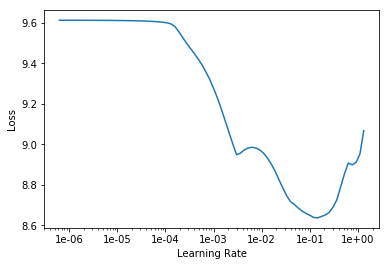

In [29]:
learn.recorder.plot(skip_end=10)

In [30]:
learn.fit_one_cycle(20, 1e-3, moms=(0.6,0.4), wd=0.02, pct_start=0.2)

epoch,train_loss,valid_loss,accuracy,time
0,5.183852,5.131800,0.241706,32:10
1,4.514515,4.455114,0.291232,33:15
2,4.158150,4.080009,0.329130,33:19
3,3.976780,3.906122,0.347923,33:13
4,3.867723,3.813419,0.358588,33:16
5,3.793557,3.756064,0.365307,33:15
6,3.732315,3.711752,0.370790,33:14
7,3.662155,3.679112,0.374951,33:16
8,3.616204,3.653128,0.378208,33:17
9,3.576602,3.630259,0.381411,33:20


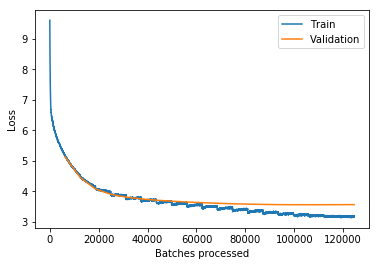

In [31]:
learn.recorder.plot_losses()

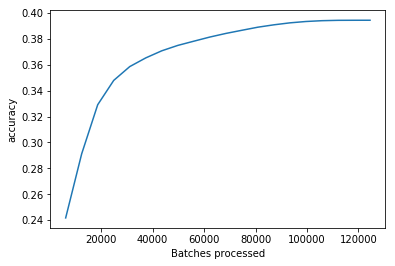

In [32]:
learn.recorder.plot_metrics() ## prob can do better with more training!

In [33]:
learn.save_encoder('twitter_es_enc_RNN_0518_labelsmooth_15k')

In [34]:
learn.save("twitter_raw_es_more_rules_15k_labelsmooth_RNN_20190518")

## Percentage of `xxunk` in each tweet.  Is it high?

In [35]:
pct_xxunk = pd.Series([sum(y==0)/len(y) for y in [x.data for x in data.train_dl.x]])
pct_xxunk[pct_xxunk>0].shape, pct_xxunk.shape

((22421,), (427631,))

In [38]:
22421/427631.

0.052430717136970895

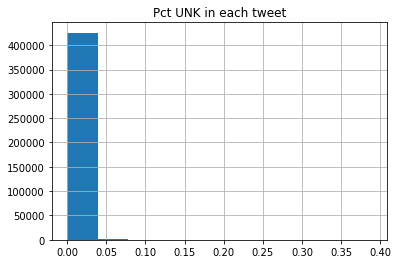

In [36]:
pct_xxunk.hist()
_ = plt.title('Pct UNK in each tweet')

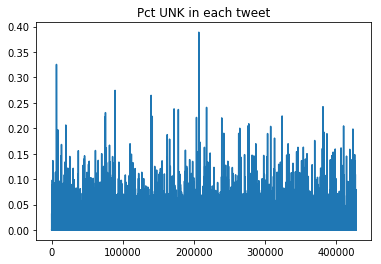

In [37]:
pct_xxunk.plot()
_ = plt.title('Pct UNK in each tweet')